# Facial Recognition with SVM and EigenFaces

Sklearn example from [sphx-glr-auto-examples-applications-plot-face-recognition-py](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py).

In [1]:
from time import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import matplotlib.pyplot as plt

In [2]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
print(lfw_people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

In [3]:

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("Shape of X: {} and y: {}".format(X.shape, y.shape))
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
Shape of X: (1288, 1850) and y: (1288,)
n_samples: 1288
n_features: 1850
n_classes: 7


In [4]:
# the first image and the target name of the image
X[0], target_names[y[0]]

(array([254.      , 254.      , 251.66667 , ...,  87.333336,  88.666664,
         86.666664], dtype=float32),
 'Hugo Chavez')

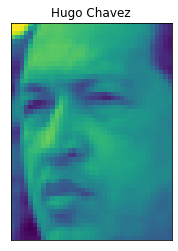

In [5]:
# plot the first image and the name of the person
plt.imshow(X[0].reshape((h, w)))
plt.title(target_names[y[0]], size=12)
plt.xticks(())
plt.yticks(())
plt.show()

In [6]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(966, 1850) (322, 1850) (966,) (322,)


In [7]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 200

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
print('Eigenface shape:', eigenfaces.shape, '', pca.components_.shape)

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))
X_train_pca.shape, X_test_pca.shape


Extracting the top 200 eigenfaces from 966 faces
done in 0.132s
Eigenface shape: (200, 50, 37)  (200, 1850)
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s


((966, 200), (322, 200))

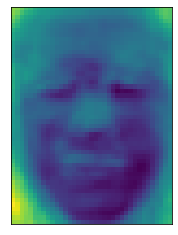

In [8]:
# plot the first image and the name of the person
plt.imshow(eigenfaces[0])
# plt.title(target_names[y[0]], size=12)
plt.xticks(())
plt.yticks(())
plt.show()

In [9]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), param_grid
)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 14.990s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


In [10]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.041s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.62      0.57        13
     Colin Powell       0.78      0.88      0.83        60
  Donald Rumsfeld       0.81      0.78      0.79        27
    George W Bush       0.89      0.90      0.89       146
Gerhard Schroeder       0.81      0.68      0.74        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.85      0.81      0.83        36

         accuracy                           0.83       322
        macro avg       0.78      0.75      0.76       322
     weighted avg       0.83      0.83      0.83       322

[[  8   2   1   2   0   0   0]
 [  2  53   1   3   0   1   0]
 [  2   1  21   3   0   0   0]
 [  3   6   3 131   2   0   1]
 [  0   2   0   3  17   1   2]
 [  0   3   0   1   0   9   2]
 [  0   1   0   4   2   0  29]]


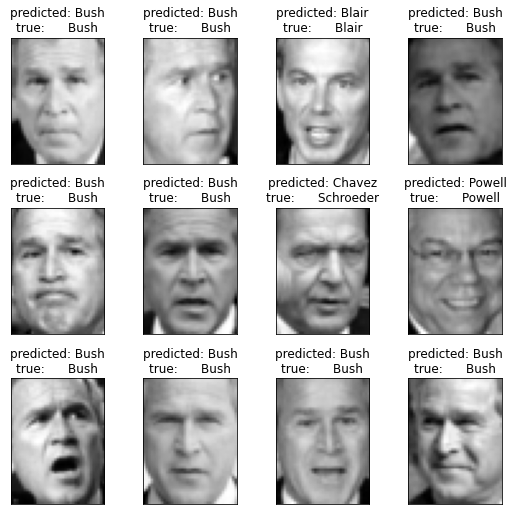

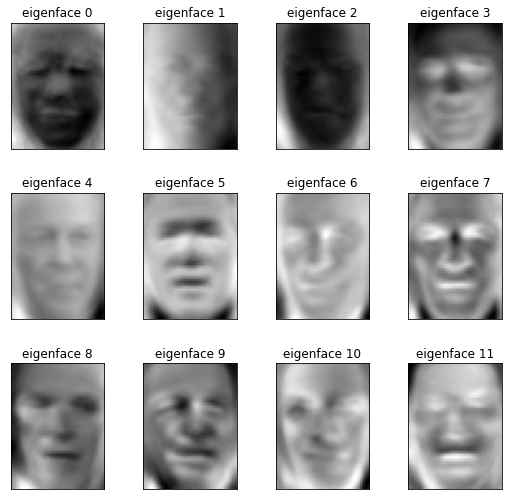

In [11]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()